In [1]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

import re
from sklearn import linear_model
import patsy

from scipy.stats import norm
import ezodf
import scipy.optimize as sco
import scipy

from sklearn.covariance import LedoitWolf
from datetime import datetime
import sklearn

## Data Analysis for Stocks

- DO DIFFEREN RANK FOR VALUE METRICS< SET TO BE HIGH RANK IS GOOD!!!!
    - Or do invesrion of these??

In [4]:
tmp_df = pd.read_csv('../data/VQ_data.csv')
tmp_df['d'] = pd.to_datetime(tmp_df['d'])
tmp_df = tmp_df.set_index(['d', 'insID'])

In [5]:
min_MCAP = 500
clean_df = tmp_df[tmp_df['MCAP']>min_MCAP]
horizon = 3
n_groups = 5

monthly_df =clean_df.groupby([clean_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
monthly_df['log_ret'] = monthly_df['adj_c'].groupby(level='insID').apply(lambda x: np.log(x.shift(-horizon)) - np.log(x))
monthly_df = monthly_df.unstack('insID').iloc[::horizon, :].stack('insID')

#Take rank of log ret per month values! Ranking forces it into a stationary distribution!!
monthly_df['rank_ret'] = monthly_df['log_ret'].groupby(level='d').rank(ascending=False)



#### CLEAN DATA


colmax_list = ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']

#set inf values to max
for col in colmax_list:
    m = monthly_df.loc[monthly_df[col] != np.inf, :].max()
    monthly_df.replace(np.inf,m,inplace=True)


#    #New method, more robust!!!
#for colmax in colmax_list:
#    max_tmp = monthly_df.loc[:,col].max()
#    monthly_df.loc[monthly_df[colmax]<0, colmax] = max_tmp

#Invesrt the values that should be low so they should be high
for colmax in colmax_list:
    monthly_df.loc[:, colmax] = (1/monthly_df[colmax])
    
    
### INDICATOR FUNCTION IF THE COMPANY IS IN FINANCE & RE
monthly_df['sector_ind'] = 0
monthly_df[monthly_df['sector'] == 'finance_RE']['sector_ind'] = 1
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Quintile analysis for forward 1 m return

In [6]:
col_list = monthly_df.columns.to_list()

for ele in ['c','number_Of_Shares', '1_day_ret','Name','volatility_60day',
                 'sector','market', 'acceleration', 'adj_mom', 'log_ret','adj_c', 'EA_ret', 'sector_ind']:
    try:
        col_list.remove(ele)
    except:
        print(ele)


col_list1 = col_list.copy()
col_list1.append('rank_ret')


zscore_df = pd.DataFrame()
zscore_df.index = monthly_df.index

for col in col_list1:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = monthly_df[col]
    zscore_tmp_df = zscore_tmp_df.dropna()
    #Rank for each day!! This makes it robust and stationary!! 
    # HIGH VALUE GIVES LOW RANK!!!
    zscore_tmp_df = zscore_tmp_df.groupby(level='d').rank(ascending=False)
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

    

model_list = []
for col in zscore_df.columns:
    x = re.search('zscore$', col)
    if(x!=None):
        model_list.append(col)

#group by quintiles 

for col in list(set(list(zscore_df.columns)) - set('rank_ret_zscore')):
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), n_groups, labels = range(1, n_groups + 1))
    
    
#Add indicator function for sector
zscore_df = zscore_df.join(monthly_df['sector_ind'], on=['d','insID'],how='left')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [7]:

##############################################    
#combined measures, redo z scores and groups!!
##############################################

zscore_df['comb_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore']
zscore_df['ear_mom'] =  zscore_df['mom6_zscore'] +zscore_df['mom12_zscore'] + zscore_df['EAR_std_zscore']
zscore_df['val_comp'] = zscore_df['PE_zscore'] + zscore_df['PB_zscore'] +zscore_df['EVEBIT_zscore'] +zscore_df['PFCF_zscore']+zscore_df['PS_zscore'] + zscore_df['Asset_growth_zscore']
zscore_df['qual_comp'] = zscore_df['GPA_zscore'] + zscore_df['ROIC_zscore'] +zscore_df['ROE_zscore'] + zscore_df['AT_zscore']+zscore_df['FCFROE_zscore']


## REDO ZSCORE AND QUANTILES FOR COMBINED MEASURES

for col in ['comb_mom', 'ear_mom', 'val_comp', 'qual_comp']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

for col in ['comb_mom_zscore', 'ear_mom_zscore', 'val_comp_zscore', 'qual_comp_zscore']:
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), n_groups, labels = range(1, n_groups + 1))

##############################################    
######### REDO FOR COMBINATION OF COMBINATIONS, VMQ, QM, VQ, VM
#################################################

zscore_df['VMQ'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['MQ'] = zscore_df['ear_mom_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VQ'] =  zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VM'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore']

## REDO ZSCORE AND QUANTILES FOR COMBINED OF COMBINED MEASURES

for col in ['VMQ', 'MQ', 'VQ', 'VM']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

for col in ['VMQ_zscore', 'MQ_zscore', 'VQ_zscore', 'VM_zscore']:
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), n_groups, labels = range(1, n_groups + 1))




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-f

In [9]:
tmp_df.columns

Index(['c', 'number_Of_Shares', 'MCAP', 'PE', 'GPA', 'GPA_chg', 'Asset_growth',
       'PB', 'EA_ret', 'EAR_std', 'AVG_EAR', 'EVEBIT', 'EVFCF', 'adj_c',
       'ROIC', 'ROE', 'ROE_chg', 'AT', 'Name', 'sector', 'market', 'RSURP_Y',
       'rev_growth', 'SUE_Y', 'EPS_growth', 'EPS_acceleration', 'mom12',
       'mom6', 'mom3', 'mom1', '1_day_ret', 'volatility', 'volatility_60day',
       'acceleration', 'adj_mom', 'sharpe', 'sharpe_6m', 'high_12m', 'high_6m',
       'high_3m', 'high_1m', 'high_2y', 'high_3y', 'high_4y', 'low_1m',
       'low_3m', 'low_6m', 'low_12m', 'low_2y', 'skew', 'EMA_32_96',
       'EMA_96_288', 'range_2y', 'range_12m', 'range_6m', 'range_3m',
       'range_1m', 'VAR_1', 'FCFROE', 'ROA', 'PS', 'PFCF', 'DIV_Y',
       'res_mom12', 'MA50_VOL', 'Gross_margin', 'beta', 'alpha', 'std_alpha',
       'ido_mom12', 'PO', 'FY', 'SY'],
      dtype='object')

## MOMENTUM MEASURES

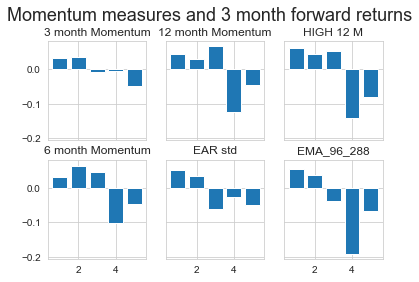

In [25]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,3, sharex=True, sharey = True)
fig.suptitle('Momentum measures and 3 month forward returns', fontsize=18, y=1)
ax[0, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("mom3_zscore_group").mean()['rank_ret_zscore']);
ax[0, 0].set_title('3 month Momentum');
ax[1, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("mom6_zscore_group").mean()['rank_ret_zscore']);
ax[1, 0].set_title('6 month Momentum');
ax[0, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("mom12_zscore_group").mean()['rank_ret_zscore']);
ax[0, 1].set_title('12 month Momentum');
ax[1, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("EAR_std_zscore_group").mean()['rank_ret_zscore']);
ax[1, 1].set_title('EAR std');
#ax[0, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("RSURP_Y_zscore_group").mean()['rank_ret_zscore']);
#ax[0, 2].set_title('RSURP_Y');
#ax[1, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("SUE_Y_zscore_group").mean()['rank_ret_zscore']);
#ax[1, 2].set_title('SUE_Y');

ax[0, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("high_12m_zscore_group").mean()['rank_ret_zscore']);
ax[0, 2].set_title('HIGH 12 M');
ax[1, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("EMA_96_288_zscore_group").mean()['rank_ret_zscore']);
ax[1, 2].set_title('EMA_96_288');


In [17]:
# sns.set_style("whitegrid")
# fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
# fig.suptitle('Momentum measures and 1 month forward returns', fontsize=18, y=1)
# ax[0].bar(range(1, n_groups + 1) ,zscore_df.groupby("comb_mom_zscore_group").mean()['rank_ret_zscore']);
# ax[0].set_title('Combined Momentum');
# ax[1].bar(range(1, n_groups + 1) ,zscore_df.groupby("ear_mom_zscore_group").mean()['rank_ret_zscore']);
# ax[1].set_title('EAR-Momentum');

### Value Measures

In [3]:
# sns.set_style("whitegrid")
# fig, ax = plt.subplots(2,4, sharex=True, sharey = True)
# fig.suptitle('Value measures and 3 month forward returns', fontsize=18, y=1)
# ax[0, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("PFCF_zscore_group").mean()['rank_ret_zscore']);
# ax[0, 0].set_title('PFCF');
# ax[1, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("PE_zscore_group").mean()['rank_ret_zscore']);
# ax[1, 0].set_title('PE');
# ax[0, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("PB_zscore_group").mean()['rank_ret_zscore']);
# ax[0, 1].set_title('PB');
# ax[1, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("Asset_growth_zscore_group").mean()['rank_ret_zscore']);
# ax[1, 1].set_title('Asset Growth');

# ax[0, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("EVEBIT_zscore_group").mean()['rank_ret_zscore']);
# ax[0, 2].set_title('EVEBIT');
# ax[1, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("DIV_Y_zscore_group").mean()['rank_ret_zscore']);
# ax[1, 2].set_title('Dividend Yield');

# ax[0, 3].bar(range(1, n_groups + 1) ,zscore_df.groupby("PS_zscore_group").mean()['rank_ret_zscore']);
# ax[0, 3].set_title('PS');
# ax[1, 3].bar(range(1, n_groups + 1) ,zscore_df.groupby("val_comp_zscore_group").mean()['rank_ret_zscore']);
# ax[1, 3].set_title('Value Composite');

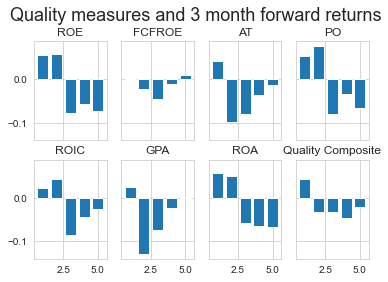

In [18]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,4, sharex=True, sharey = True)
fig.suptitle('Quality measures and 3 month forward returns', fontsize=18, y=1)
ax[0, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("ROE_zscore_group").mean()['rank_ret_zscore']);
ax[0, 0].set_title('ROE');
ax[1, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("ROIC_zscore_group").mean()['rank_ret_zscore']);
ax[1, 0].set_title('ROIC');
ax[0, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("FCFROE_zscore_group").mean()['rank_ret_zscore']);
ax[0, 1].set_title('FCFROE');
ax[1, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("GPA_zscore_group").mean()['rank_ret_zscore']);
ax[1, 1].set_title('GPA');

ax[0, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("AT_zscore_group").mean()['rank_ret_zscore']);
ax[0, 2].set_title('AT');
ax[1, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("ROA_zscore_group").mean()['rank_ret_zscore']);
ax[1, 2].set_title('ROA');

ax[0, 3].bar(range(1, n_groups + 1) ,zscore_df.groupby("PO_zscore_group").mean()['rank_ret_zscore']);
ax[0, 3].set_title('PO');

ax[1, 3].bar(range(1, n_groups + 1) ,zscore_df.groupby("qual_comp_zscore_group").mean()['rank_ret_zscore']);
ax[1, 3].set_title('Quality Composite');


In [19]:
# sns.set_style("whitegrid")
# plt.bar(range(1, n_groups + 1), zscore_df.groupby("VMQ_zscore_group").mean()['rank_ret_zscore']);
# plt.title('VMQ');

In [20]:
# sns.set_style("whitegrid")
# plt.bar(range(1, n_groups + 1), zscore_df.groupby("MQ_zscore_group").mean()['rank_ret_zscore']);
# plt.title('QM');

In [21]:
# sns.set_style("whitegrid")
# plt.bar(range(1, n_groups + 1), zscore_df.groupby("VM_zscore_group").mean()['rank_ret_zscore']);
# plt.title('VM');

In [22]:
# sns.set_style("whitegrid")
# plt.bar(range(1, n_groups + 1), zscore_df.groupby("VQ_zscore_group").mean()['rank_ret_zscore']);
# plt.title('VQ');

In [23]:
# sns.set_style("whitegrid")
# plt.bar(range(1, n_groups + 1), zscore_df.groupby("volatility_zscore_group").mean()['rank_ret_zscore']);
# plt.title('Volatility');

In [24]:
# sns.set_style("whitegrid")
# plt.bar(range(1, n_groups + 1), zscore_df.groupby("sharpe_zscore_group").mean()['rank_ret_zscore']);
# plt.title('Sharpe');

## SIMPEL LINEAR MODEL

In [26]:
coeff_list_full = model_list.copy()
coeff_list = coeff_list_full
coeff_list.remove('rank_ret_zscore')


In [27]:
coeff_list

['MCAP_zscore',
 'PE_zscore',
 'GPA_zscore',
 'GPA_chg_zscore',
 'Asset_growth_zscore',
 'PB_zscore',
 'EAR_std_zscore',
 'AVG_EAR_zscore',
 'EVEBIT_zscore',
 'EVFCF_zscore',
 'ROIC_zscore',
 'ROE_zscore',
 'ROE_chg_zscore',
 'AT_zscore',
 'RSURP_Y_zscore',
 'rev_growth_zscore',
 'SUE_Y_zscore',
 'EPS_growth_zscore',
 'EPS_acceleration_zscore',
 'mom12_zscore',
 'mom6_zscore',
 'mom3_zscore',
 'mom1_zscore',
 'volatility_zscore',
 'sharpe_zscore',
 'sharpe_6m_zscore',
 'high_12m_zscore',
 'high_6m_zscore',
 'high_3m_zscore',
 'high_1m_zscore',
 'high_2y_zscore',
 'high_3y_zscore',
 'high_4y_zscore',
 'low_1m_zscore',
 'low_3m_zscore',
 'low_6m_zscore',
 'low_12m_zscore',
 'low_2y_zscore',
 'skew_zscore',
 'EMA_32_96_zscore',
 'EMA_96_288_zscore',
 'range_2y_zscore',
 'range_12m_zscore',
 'range_6m_zscore',
 'range_3m_zscore',
 'range_1m_zscore',
 'VAR_1_zscore',
 'FCFROE_zscore',
 'ROA_zscore',
 'PS_zscore',
 'PFCF_zscore',
 'DIV_Y_zscore',
 'res_mom12_zscore',
 'MA50_VOL_zscore',
 'Gr

In [28]:
coeff_list_comp = coeff_list

In [29]:
coeff_list_comp = ['EVEBIT_zscore','Asset_growth_zscore', 'PS_zscore', 'PB_zscore', 'PE_zscore',
                  'ROIC_zscore','ROE_zscore','GPA_zscore','AT_zscore', 'ROA_zscore',
                   'EAR_std_zscore','mom12_zscore', 'mom6_zscore','mom3_zscore','res_mom12_zscore', 'sharpe_zscore']

## 1 month returns

In [40]:
#coeff_list_comp = ['qual_comp_zscore', 'val_comp_zscore', 'ear_mom_zscore'] + ['volatility_zscore']

#coeff_list_comp = ['mom1_zscore', 'ear_mom_zscore', 'volatility_zscore']

#coeff_list_comp = [ 'volatility_zscore', 'mom12_zscore', 'EAR_std_zscore', 'sharpe_zscore']
#coeff_list_comp = ['EMA_96_288_zscore', 'EMA_32_96_zscore']


#coeff_list_comp = ['EAR_std_zscore']
#coeff_list_comp = ['EVEBIT_zscore','Asset_growth_zscore', 'PS_zscore', 'PB_zscore', 'PE_zscore' ]
#coeff_list_comp = [ 'EAR_std_zscore','mom12_zscore', 'mom6_zscore','mom3_zscore','res_mom12_zscore', 'sharpe_zscore']

coeff_list_comp = ['ROIC_zscore','ROE_zscore','GPA_zscore','AT_zscore', 'ROA_zscore', 'PO_zscore']
#coeff_list_comp = [ 'EAR_std_zscore', 'mom12_zscore']
#coeff_list_comp = ['EAR_std_zscore','res_mom12_zscore', 'sharpe_zscore', 'mom12_zscore']
coeff_list_comp = ['EMA_32_96_zscore','EMA_96_288_zscore','EAR_std_zscore','mom12_zscore', 'mom6_zscore',
                   'mom3_zscore', 'res_mom12_zscore', 'sharpe_zscore', 'high_12m_zscore']


#coeff_list_comp = ['VMQ_zscore']
 

INTERACTIONS = False

y_factor = 'rank_ret_zscore'

y = pd.DataFrame(zscore_df[y_factor])
X = zscore_df[coeff_list_comp]

model_list = coeff_list_comp.copy()
model_list.append(y_factor)

formula = y.columns[0] + ' ~ ' 

coeff_list_comp_tmp = coeff_list_comp

if INTERACTIONS == True:

    for coeff in coeff_list_comp_tmp:
            formula = formula + coeff + " + " 
    for coeff_i in coeff_list_comp_tmp:
        for coeff_j in coeff_list_comp_tmp:
            if coeff_i != coeff_j:
                formula = formula + coeff_i+":"+ coeff_j + " + "
else:
    for coeff in coeff_list_comp_tmp:
            formula = formula + coeff + " + " 
                
                             
formula = formula[:-3]
formula = formula + "-1" #no intercept

reg_df = zscore_df.dropna()



### MAKE NEGATIVE values positive for ranking

#turn_positive = ['res_mom12_zscore','mom12_zscore', 'mom6_zscore', 'mom3_zscore','high_2y_zscore', 'high_12m_zscore',
#        'high_6m_zscore', 'high_3m_zscore','high_1m_zscore', 'EAR_std_zscore','AVG_EAR_zscore','qual_comp_zscore', 'VMQ_zscore',
#                 'val_comp_zscore','ear_mom_zscore', 'EMA_32_96_zscore', 'EMA_96_288_zscore', 'sharpe_zscore' ]
#
#reg_df.loc[:,turn_positive ] = -reg_df.loc[:,turn_positive ]


est2 = smf.ols(formula= formula, data=reg_df[model_list]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
print(est2.summary())


                                 OLS Regression Results                                
Dep. Variable:        rank_ret_zscore   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              14.02
Date:                Fri, 27 May 2022   Prob (F-statistic):                    9.19e-23
Time:                        08:08:56   Log-Likelihood:                         -20540.
No. Observations:               14540   AIC:                                  4.110e+04
Df Residuals:                   14531   BIC:                                  4.117e+04
Df Model:                           9                                                  
Covariance Type:                  HAC                                                  
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

In [41]:
reg_coeffs = pd.DataFrame(est2.params)
reg_coeffs.columns = ['coeff']
reg_coeffs['Weights'] = reg_coeffs['coeff']/reg_coeffs['coeff'].sum()
reg_coeffs

,coeff,Weights
EMA_32_96_zscore,-0.018746,0.243248
EMA_96_288_zscore,-0.016023,0.207917
EAR_std_zscore,-0.025062,0.325203
mom12_zscore,0.059170,-0.767793
mom6_zscore,0.017118,-0.222120
mom3_zscore,0.000137,-0.001782
res_mom12_zscore,0.008821,-0.114466
sharpe_zscore,-0.070913,0.920170
high_12m_zscore,-0.031568,0.409623


In [32]:
from sklearn.linear_model import Ridge
y, X = patsy.dmatrices(formula, reg_df[model_list], return_type='dataframe')
clf = Ridge(alpha=1)
clf.fit(X, y)
ridge_coef = pd.DataFrame(clf.coef_)
ridge_coef.columns = X.columns
reg_coeffs_alt = ridge_coef.transpose().sort_values(by = 0, key=abs, ascending=False)

reg_coeffs_alt.columns = ['coeff']
reg_coeffs_alt['Weights'] = reg_coeffs_alt['coeff']/reg_coeffs_alt['coeff'].sum()
reg_coeffs_alt

,coeff,Weights
PO_zscore,-0.034471,0.612289
ROA_zscore,-0.031920,0.566972
ROIC_zscore,0.023911,-0.424721
ROE_zscore,-0.018582,0.330061
GPA_zscore,0.006426,-0.114145
AT_zscore,-0.001663,0.029544


In [33]:
zscore_df[coeff_list_comp].groupby(level='insID').diff(horizon).abs().mean()

ROIC_zscore    0.282011
ROE_zscore     0.311157
GPA_zscore     0.179998
AT_zscore      0.165292
ROA_zscore     0.308161
PO_zscore      0.283007
dtype: float64

## Correlation Analysis

In [35]:
zscore_df[coeff_list_comp].corr(method = 'spearman')

,ROIC_zscore,ROE_zscore,GPA_zscore,AT_zscore,ROA_zscore,PO_zscore
ROIC_zscore,1.000000,0.695306,0.355591,0.350425,0.681270,0.449198
ROE_zscore,0.695306,1.000000,0.233708,0.272062,0.822983,0.481955
GPA_zscore,0.355591,0.233708,1.000000,0.629236,0.320509,0.203534
AT_zscore,0.350425,0.272062,0.629236,1.000000,0.290258,0.306986
ROA_zscore,0.681270,0.822983,0.320509,0.290258,1.000000,0.483664
PO_zscore,0.449198,0.481955,0.203534,0.306986,0.483664,1.000000


In [36]:
import pandas as pd
import scipy.cluster.hierarchy as spc

corr = zscore_df[coeff_list_comp].corr(method = 'spearman').values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
#idx = spc.fcluster(linkage, 3, 'maxclust')

reg_coeffs_alt['cluster'] = idx

reg_coeffs_alt

,coeff,Weights,cluster
PO_zscore,-0.034471,0.612289,2
ROA_zscore,-0.031920,0.566972,2
ROIC_zscore,0.023911,-0.424721,1
ROE_zscore,-0.018582,0.330061,1
GPA_zscore,0.006426,-0.114145,2
AT_zscore,-0.001663,0.029544,3


In [37]:
def Optimize_Portfolio(data ,risk_free = 0, objective = 'Kelly'):
    

    
    
    if objective == 'Kelly':  
        #ret = (data).prod()**(1/len(data)) - 1 #cagr
        ret = (data-1).mean()
        #cov = data.cov().to_numpy()
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        #need smaller step size
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                      {'type':'ineq', 'fun': lambda x: 1 - np.sum(x)}) # sum <= 1
                      #{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        
        
        result = sco.minimize(kelly_objective, num_assets*[1./num_assets,], args=args, 
                                  method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001) 
        
    elif objective == 'Sharpe':
        ret = (data-1).mean() 
      
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        result = sco.minimize(sharpe_objective, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
    
    elif objective == 'Max Div':
        num_assets = len(data.columns)
        #cov = data.cov().to_numpy()
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(calc_diversification_ratio, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
        
    elif objective == "min var":
        num_assets = len(data.columns)
        
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(port_var, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
    elif objective == "erc":
        num_assets = len(data.columns)
        #cov = data.cov().to_numpy()
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(erc, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
        
        
        
    
    return (result)

def kelly_objective(weights,ret, cov, risk_free = 0):
    
    #kelly_ret = port_ret(weights, ret)
    kelly_ret = port_ret(weights, ret) - port_var(weights, cov)/2
    
    obj = -(kelly_ret)
    
    return(obj)

def sharpe_objective(weights,ret, cov, risk_free = 0):
    ret = port_ret(weights, ret)
    std = port_var(weights, cov)**(1/2)
    
    obj = - (ret/std)
    return(obj)


def port_var(weights, cov):
    var = weights.dot(cov).dot(weights)
    return(var)

def port_ret(weights, ret, risk_free = 0):
    #needs to be array
    ret = ret - risk_free
    port_ret = weights.dot(ret)
    return(port_ret)

def risk_parity(data):
    vol = np.log((data)).std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)


def calc_diversification_ratio(weights, cov):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(cov)), weights.T)
    # portfolio vol
    port_vol = np.sqrt(port_var(weights, cov))
    
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def erc(weights, cov):
        # these are non normalized risk contributions, i.e. not regularized
        # by total risk, seems to help numerically
        risk_contributions = np.dot(weights, cov) * weights
        a = np.reshape(risk_contributions, (len(risk_contributions), 1))
        # broadcasts so you get pairwise differences in risk contributions
        risk_diffs = a - a.transpose()
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
        # https://stackoverflow.com/a/36685019/1451311
        return sum_risk_diffs_squared #/ scale_factorcov



In [38]:
df_tmp = zscore_df[coeff_list_comp].dropna()

num_assets = len(df_tmp.columns)
#cov = data.cov().to_numpy()
        
cov_fit = LedoitWolf().fit(df_tmp)
cov = cov_fit.covariance_
        
args = (cov)
constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
result = sco.minimize(calc_diversification_ratio, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)

#result = sco.minimize(erc, num_assets*[1./num_assets,], args=args, 
#                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)

In [39]:
res = pd.DataFrame(result['x']).transpose()

res.columns = coeff_list_comp
res

,ROIC_zscore,ROE_zscore,GPA_zscore,AT_zscore,ROA_zscore,PO_zscore
0,0.104462,0.177136,0.231009,0.178682,0.068683,0.240028
